In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
NOTEBOOK_NAME = 'overlaps_withinSession_post'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../autorestore/%s/' % (notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
animals = 'c3m1', 'c3m2','c10m6','c10m8','c3f3',#'90','90_475', '91','93_500','93_580','93_720','93_810',
trial = ['rewardt','CSmt','STIM1t','STIM2t','STIM3t','STIM4t']
feature = ['','_tr', '_us','_licks']
direction = ['','_up', '_dn']
for f in feature:
    for d in direction:
        for t in trial:
            try:
                what = np.concatenate([ut.load_variable('cells_%s%s%s'%(t,d,f),
                                       folder='../%s/post/notebooks/autorestore/tuning_stability_values_JSB/'%ani)
                                       for ani in animals])
                exec('cells_%s%s%s = what'%(t,d,f))
            except:
                print('failed cells_%s%s%s'%(t,d,f))

#                 exec('cells_%s%s_%s = ut.load_variable(\'cells_%s%s_%s\', folder=\'./autorestore/tuning_stability_values/\')'%(c,a,b,c, a, b))
##        exec('cells_%s%s_%s = what'%(c, a, b))
#    except IOError:
#        print("Skip", a, b, c)

failed cells_CSmt_licks
failed cells_STIM1t_licks
failed cells_STIM2t_licks
failed cells_STIM3t_licks
failed cells_STIM4t_licks
failed cells_CSmt_up_licks
failed cells_STIM1t_up_licks
failed cells_STIM2t_up_licks
failed cells_STIM3t_up_licks
failed cells_STIM4t_up_licks
failed cells_CSmt_dn_licks
failed cells_STIM1t_dn_licks
failed cells_STIM2t_dn_licks
failed cells_STIM3t_dn_licks
failed cells_STIM4t_dn_licks


In [8]:
print len(cells_rewardt)
print len(cells_CSmt_up_tr)

378
378


In [9]:
N = len(cells_rewardt) #just a placeholder for below
n_loops = 10000

def calc_shuffle_overlap(pop1, pop2, n_loops=n_loops, N=N):
     return [(np.random.choice([0, 1], size=N, p=(1-pop1.mean(), pop1.mean()))*
                  np.random.choice([0, 1], size=N, p=(1-pop2.mean(), pop2.mean()))).mean() for r in range(n_loops)]

In [10]:
def sigtest(values, x):
    pval = [1 - sstats.norm(np.mean(values), np.std(values)).cdf(x)]
    print 'p-value = ',
    print pval
    return [None, 1 - sstats.norm(np.mean(values), np.std(values)).cdf(x)]
def plot_hist(ax, vals, colors=['0.7', 'k'], bins=np.linspace(0, 0.3, 20), ids=[0, 1]):
    # ax.hist(vals2_all[0], bins=10, histtype='step', color='0.7')
    y, x = np.histogram(vals[ids[0]], bins=bins, normed=True)
    ax.step(x[:-1], y*np.diff(x)[0], color=colors[0], lw=1, where='post')
    ax.vlines(vals[ids[1]], 0, 0.4, color=colors[1], lw=1, zorder=19)
    y = np.diff(ax.axis()[-2:])*0.95 + ax.axis()[-2]
    pt.add_significance(ax, vals[ids[0]], vals[ids[1]], vals[ids[1]], vals[ids[1]], 0.5, sig_func=sigtest)
    pt.nicer_plot(ax)

In [11]:
def plot_it(pop1, pop2, untuned, est, labels=['Pre', 'Post', 'Pre+Post', 'Untuned'], title="Sucrose",
            colors=[(1, 0., 0.2), (1, 0.5, 0.2), (1, 0.8, 0.2), (0.8, 0.8, 0.8)],
            hist_colors=[(1, 0.7, 0.7), 'r']):
    fig, axs = pl.subplots(1, 2, figsize=(3, 1))

    ax = axs[0]
    plot_hist(ax, [est, (pop1*pop2).mean()], bins=np.linspace(0, 0.3, 17),
            colors=hist_colors)

    ax.set_xlabel('Co-tuned Cells Ratio')
    ax.set_ylabel('PDF')

    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 0.5)

    ax = axs[1]
    
    t = map(sum, [pop1*~pop2, pop2*~pop1, pop1*pop2, untuned])
    total = np.sum(t)
    _, txts, _ = ax.pie(t, colors=colors, explode=[0.05]*len(t),
                        autopct=lambda x: "%.1f%%"%(x),
                        labels=labels,
                        textprops={'fontsize':3})
    for tt in txts:
        tt.set_fontsize(5)
    ax.text(1, -1.3, 'n = %d'%total, fontsize=3)

    ax.set_aspect('equal')
    fig.suptitle(title)
    
    return fig, axs,

In [12]:
#set colors for figures
r1='lightskyblue'
r2='lightblue'
r12='royalblue'
s1='lightcoral'
s2='r'
s12='crimson'
c1='burlywood'
c2='peru'
c12='sienna'
f1='palegoldenrod'
f2='khaki'
f12='goldenrod'
b1='lightgreen'
b2='greenyellow'
b12='olivedrab'
g='lightgrey'

In [13]:
#initialize dictionary for chance vs observed overlap comparison
#entries will be mean chance overlap, observed overlap, observed-chance, (observed-chance)/chance,
    #z-score:(observed-chance)/STDev chance
diff_from_chance = {}

p-value =  [0.094184212368734199]
p-value =  [0.094184212368734199]


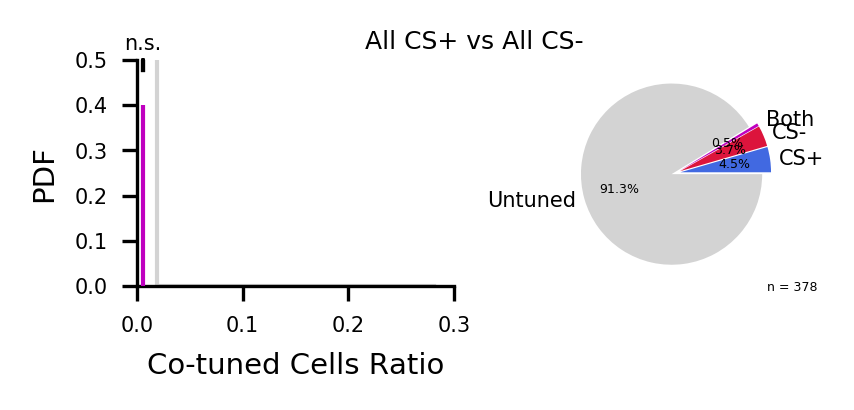

In [14]:
comparison = 'rewardt_vs_CSmt'
#try:
pop1 = cells_rewardt
pop2 = cells_CSmt
unt = ~(cells_rewardt + cells_CSmt)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r12,s12,'m',g], hist_colors=[g,'m'],
                  title='All CS+ vs All CS-', labels=['CS+', 'CS-', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
#print pval
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.41649435082532127]
p-value =  [0.41649435082532127]


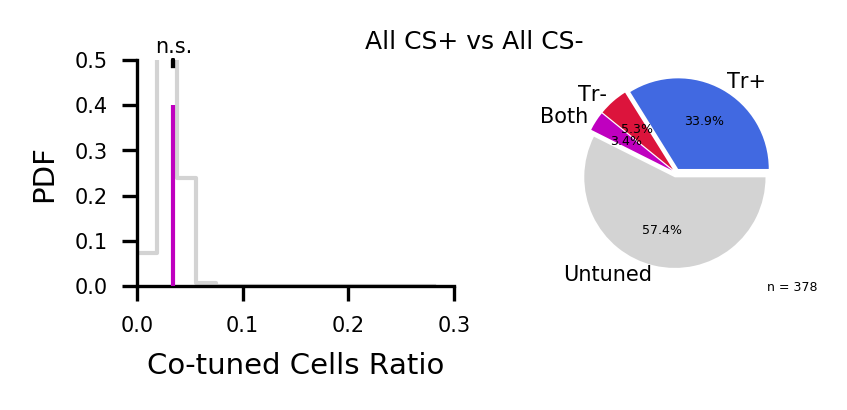

In [15]:
comparison = 'rewardt_tr_vs_CSmt_tr'
#try:
pop1 = cells_rewardt_tr
pop2 = cells_CSmt_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r12,s12,'m',g], hist_colors=[g,'m'],
                  title='All CS+ vs All CS-', labels=['Tr+', 'Tr-', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.23153513799718262]
p-value =  [0.23153513799718262]


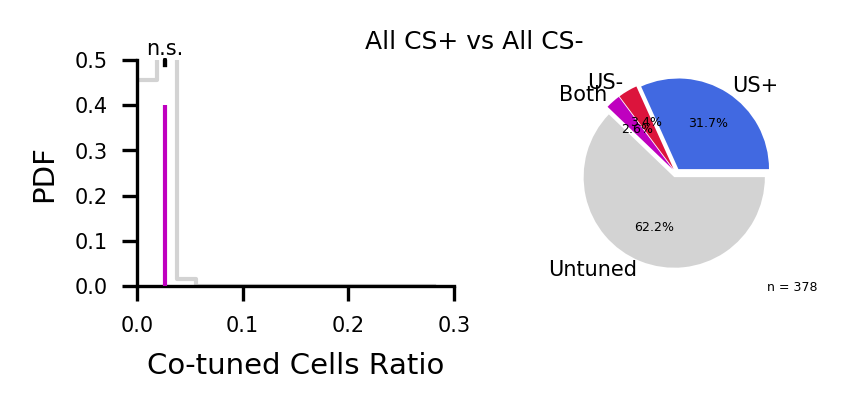

In [16]:
comparison = 'rewardt_us_vs_CSmt_us'
#try:
pop1 = cells_rewardt_us
pop2 = cells_CSmt_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r12,s12,'m',g], hist_colors=[g,'m'],
                  title='All CS+ vs All CS-', labels=['US+', 'US-', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.76881335210039325]
p-value =  [0.76881335210039325]


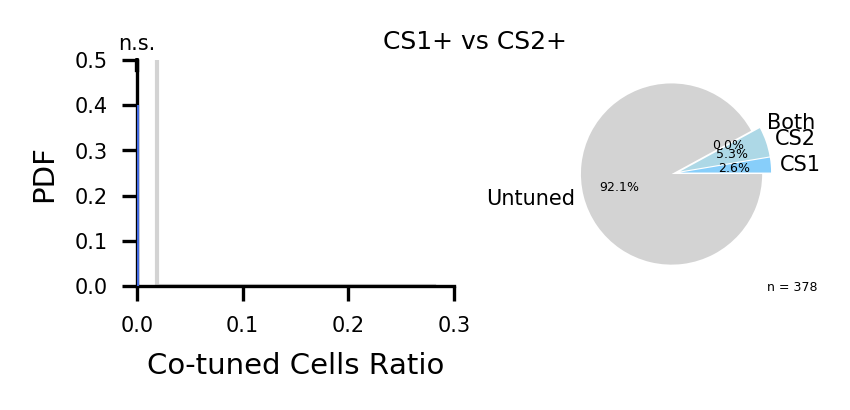

In [17]:
comparison = 'CS1_vs_CS2'
#try:
pop1 = cells_STIM1t
pop2 = cells_STIM2t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,r2,r12,g], hist_colors=[g,r12],
                  title='CS1+ vs CS2+', labels=['CS1', 'CS2', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [2.8134513208044609e-07]
p-value =  [2.8134513208044609e-07]


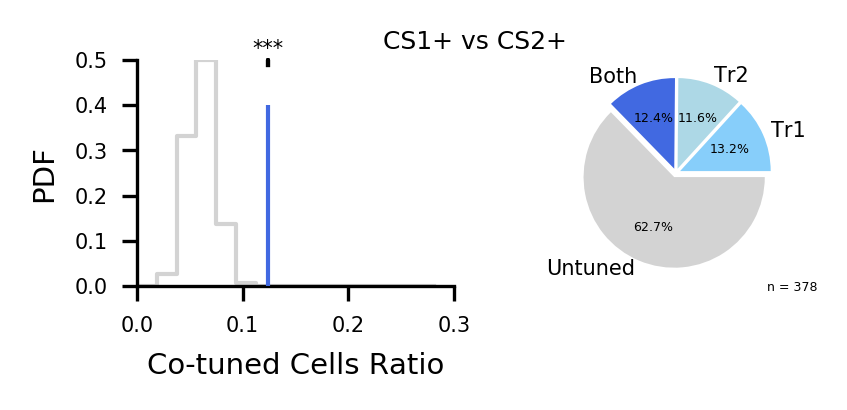

In [18]:
comparison = 'CS1_tr_vs_CS2_tr'
#try:
pop1 = cells_STIM1t_tr
pop2 = cells_STIM2t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,r2,r12,g], hist_colors=[g,r12],
                  title='CS1+ vs CS2+', labels=['Tr1', 'Tr2', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [1.9307090926012904e-08]
p-value =  [1.9307090926012904e-08]


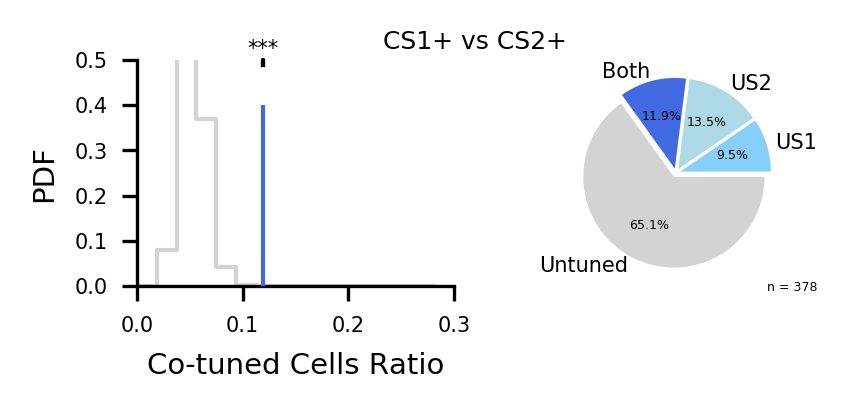

In [19]:
comparison = 'CS1_us_vs_CS2_us'
#try:
pop1 = cells_STIM1t_us
pop2 = cells_STIM2t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,r2,r12,g], hist_colors=[g,r12],
                  title='CS1+ vs CS2+', labels=['US1', 'US2', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.72947090473870113]
p-value =  [0.72947090473870113]


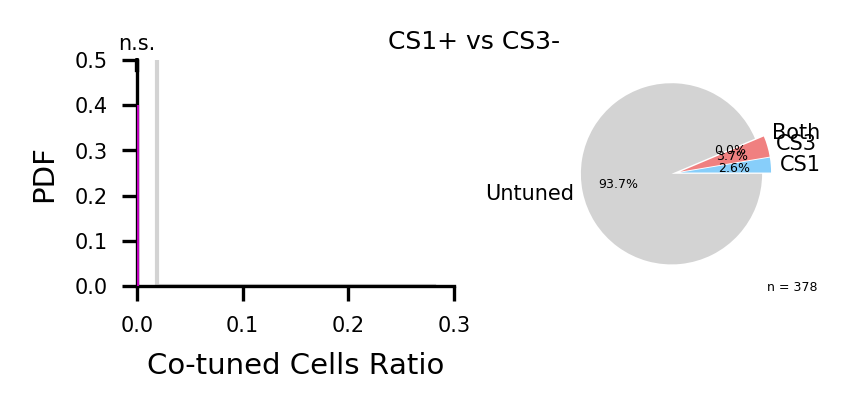

In [20]:
comparison = 'CS1_vs_CS3'
#try:
pop1 = cells_STIM1t
pop2 = cells_STIM3t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s1,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS3-', labels=['CS1', 'CS3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.70777334793662383]
p-value =  [0.70777334793662383]


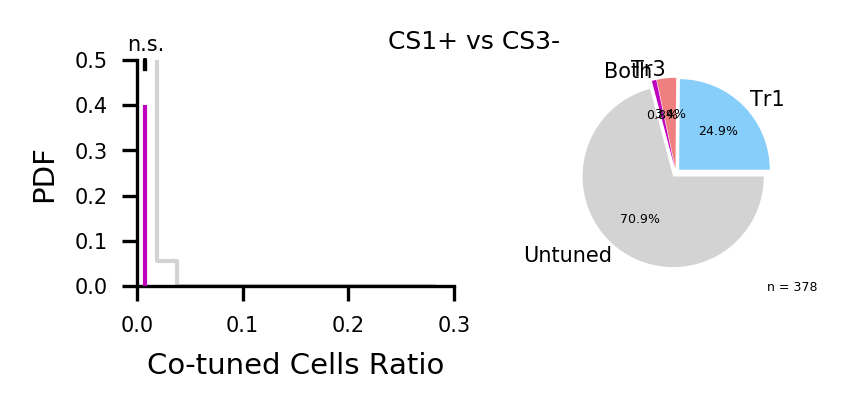

In [21]:
comparison = 'CS1_tr_vs_CS3_tr'
#try:
pop1 = cells_STIM1t_tr
pop2 = cells_STIM3t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s1,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS3-', labels=['Tr1', 'Tr3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.16167218618823154]
p-value =  [0.16167218618823154]


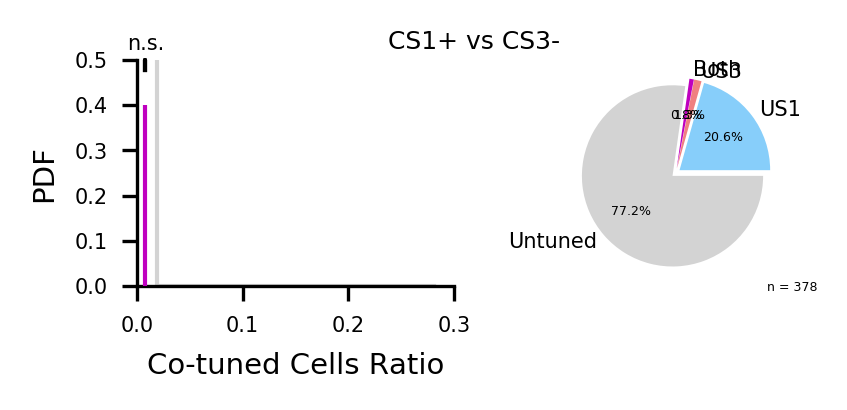

In [22]:
comparison = 'CS1_us_vs_CS3_us'
#try:
pop1 = cells_STIM1t_us
pop2 = cells_STIM3t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s1,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS3-', labels=['US1', 'US3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [7.2851654882022387e-06]
p-value =  [7.2851654882022387e-06]


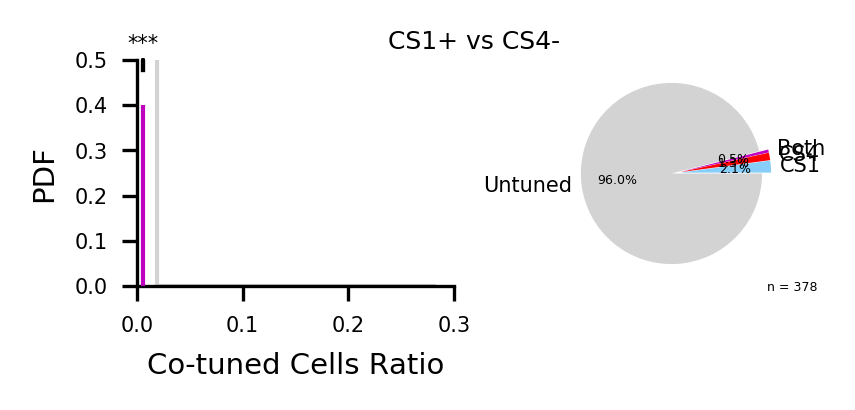

In [23]:
comparison = 'CS1_vs_CS4'
#try:
pop1 = cells_STIM1t
pop2 = cells_STIM4t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s2,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS4-', labels=['CS1', 'CS4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.1368690066433853]
p-value =  [0.1368690066433853]


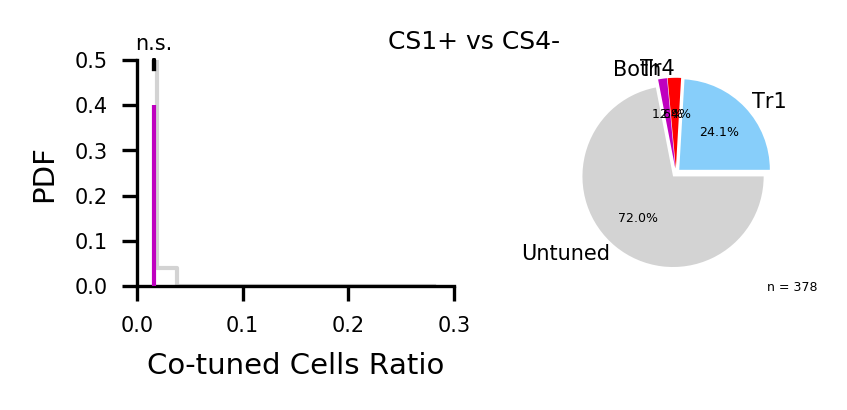

In [24]:
comparison = 'CS1_tr_vs_CS4_tr'
#try:
pop1 = cells_STIM1t_tr
pop2 = cells_STIM4t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s2,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS4-', labels=['Tr1', 'Tr4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.20394515612338715]
p-value =  [0.20394515612338715]


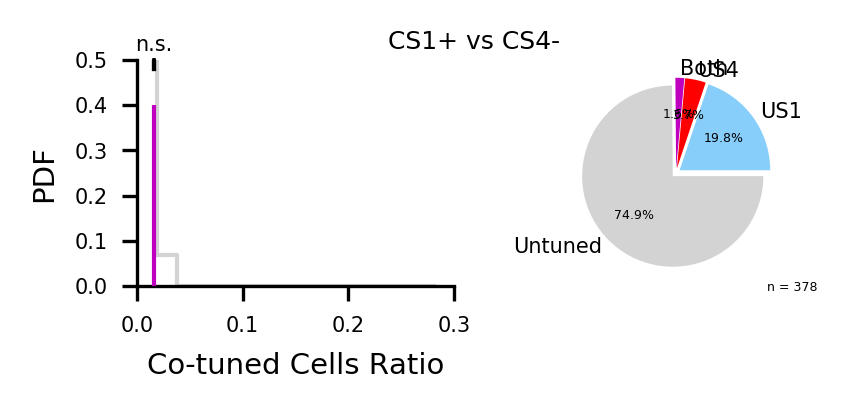

In [25]:
comparison = 'CS1_us_vs_CS4_us'
#try:
pop1 = cells_STIM1t_us
pop2 = cells_STIM4t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s2,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS4-', labels=['US1', 'US4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.38328108328441257]
p-value =  [0.38328108328441257]


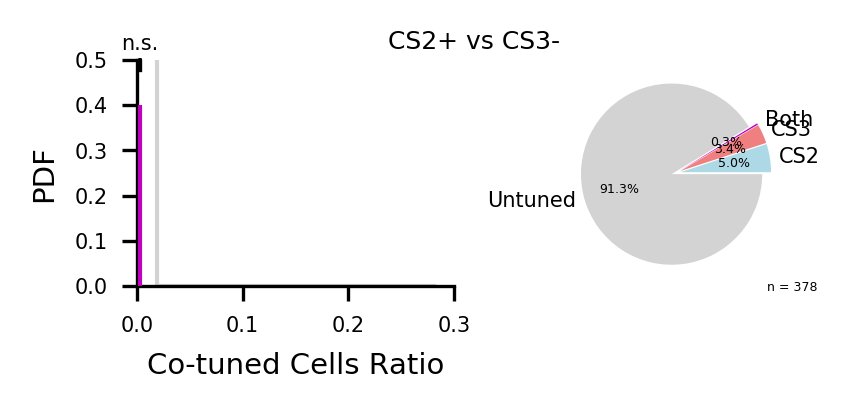

In [26]:
comparison = 'CS2_vs_CS3'
#try:
pop1 = cells_STIM2t
pop2 = cells_STIM3t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s1,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS3-', labels=['CS2', 'CS3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.67021205996778999]
p-value =  [0.67021205996778999]


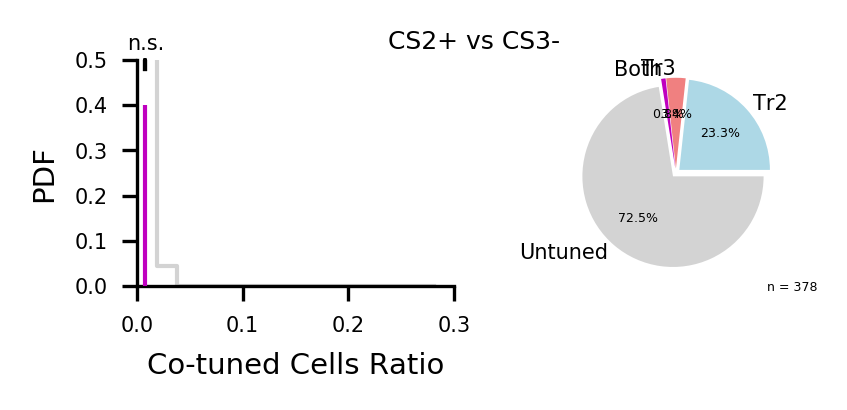

In [27]:
comparison = 'CS2_tr_vs_CS3_tr'
#try:
pop1 = cells_STIM2t_tr
pop2 = cells_STIM3t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s1,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS3-', labels=['Tr2', 'Tr3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.76424811377223323]
p-value =  [0.76424811377223323]


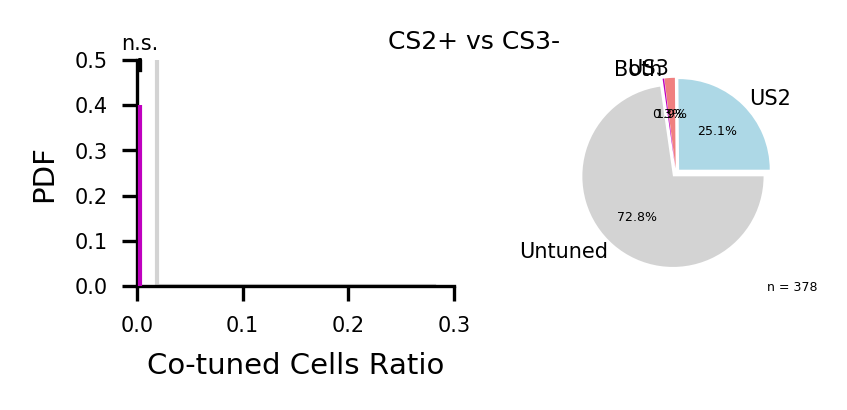

In [28]:
comparison = 'CS2_us_vs_CS3_us'
#try:
pop1 = cells_STIM2t_us
pop2 = cells_STIM3t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s1,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS3-', labels=['US2', 'US3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.14424879740468355]
p-value =  [0.14424879740468355]


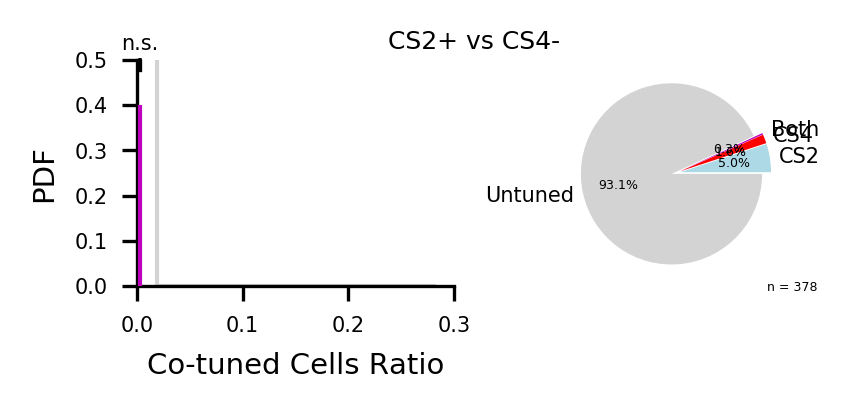

In [29]:
comparison = 'CS2_vs_CS4'
#try:
pop1 = cells_STIM2t
pop2 = cells_STIM4t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s2,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS4-', labels=['CS2', 'CS4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.036338695510171992]
p-value =  [0.036338695510171992]


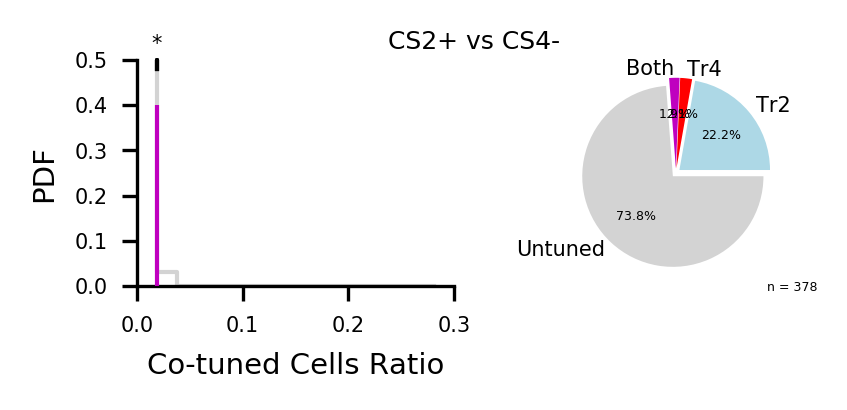

In [30]:
comparison = 'CS2_tr_vs_CS4_tr'
#try:
pop1 = cells_STIM2t_tr
pop2 = cells_STIM4t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s2,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS4-', labels=['Tr2', 'Tr4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.34326209638583527]
p-value =  [0.34326209638583527]


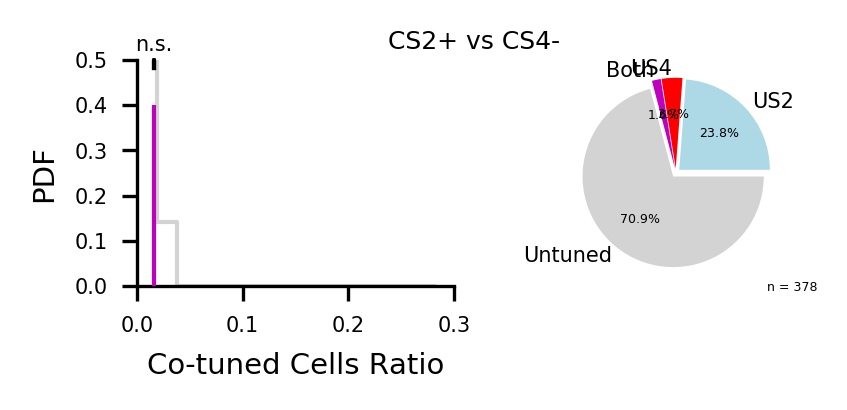

In [31]:
comparison = 'CS2_us_vs_CS4_us'
#try:
pop1 = cells_STIM2t_us
pop2 = cells_STIM4t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s2,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS4-', labels=['US2', 'US4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.69449112831771154]
p-value =  [0.69449112831771154]


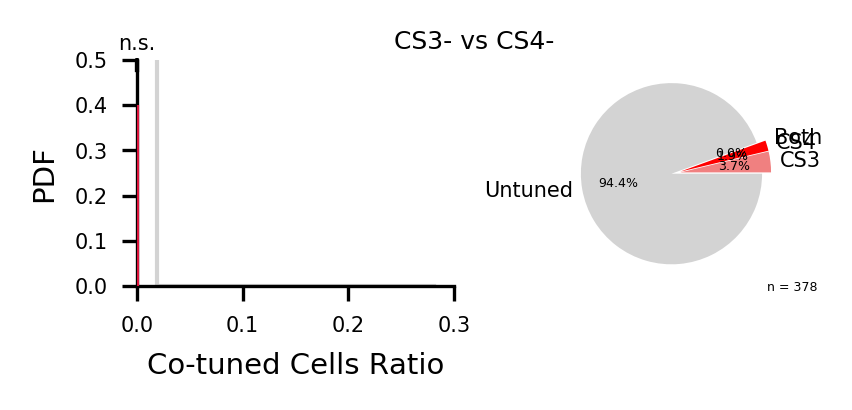

In [32]:
comparison = 'CS3_vs_CS4'
#try:
pop1 = cells_STIM3t
pop2 = cells_STIM4t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[s1,s2,s12,g], hist_colors=[g,s12],
                  title='CS3- vs CS4-', labels=['CS3', 'CS4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.33256958428708394]
p-value =  [0.33256958428708394]


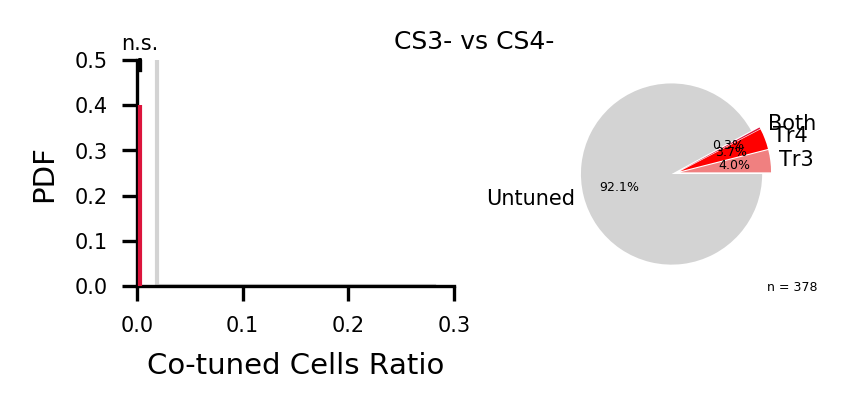

In [33]:
comparison = 'CS3_tr_vs_CS4_tr'
#try:
pop1 = cells_STIM3t_tr
pop2 = cells_STIM4t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[s1,s2,s12,g], hist_colors=[g,s12],
                  title='CS3- vs CS4-', labels=['Tr3', 'Tr4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.74370956172116809]
p-value =  [0.74370956172116809]


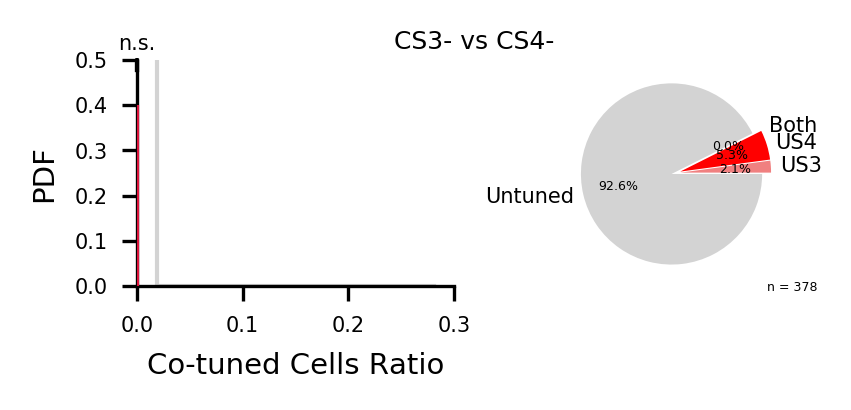

In [34]:
comparison = 'CS3_us_vs_CS4_us'
#try:
pop1 = cells_STIM3t_us
pop2 = cells_STIM4t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[s1,s2,s12,g], hist_colors=[g,s12],
                  title='CS3- vs CS4-', labels=['US3', 'US4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

In [35]:
#diff_from_chance.iterkeys()

In [36]:
#sorted(diff_from_chance)

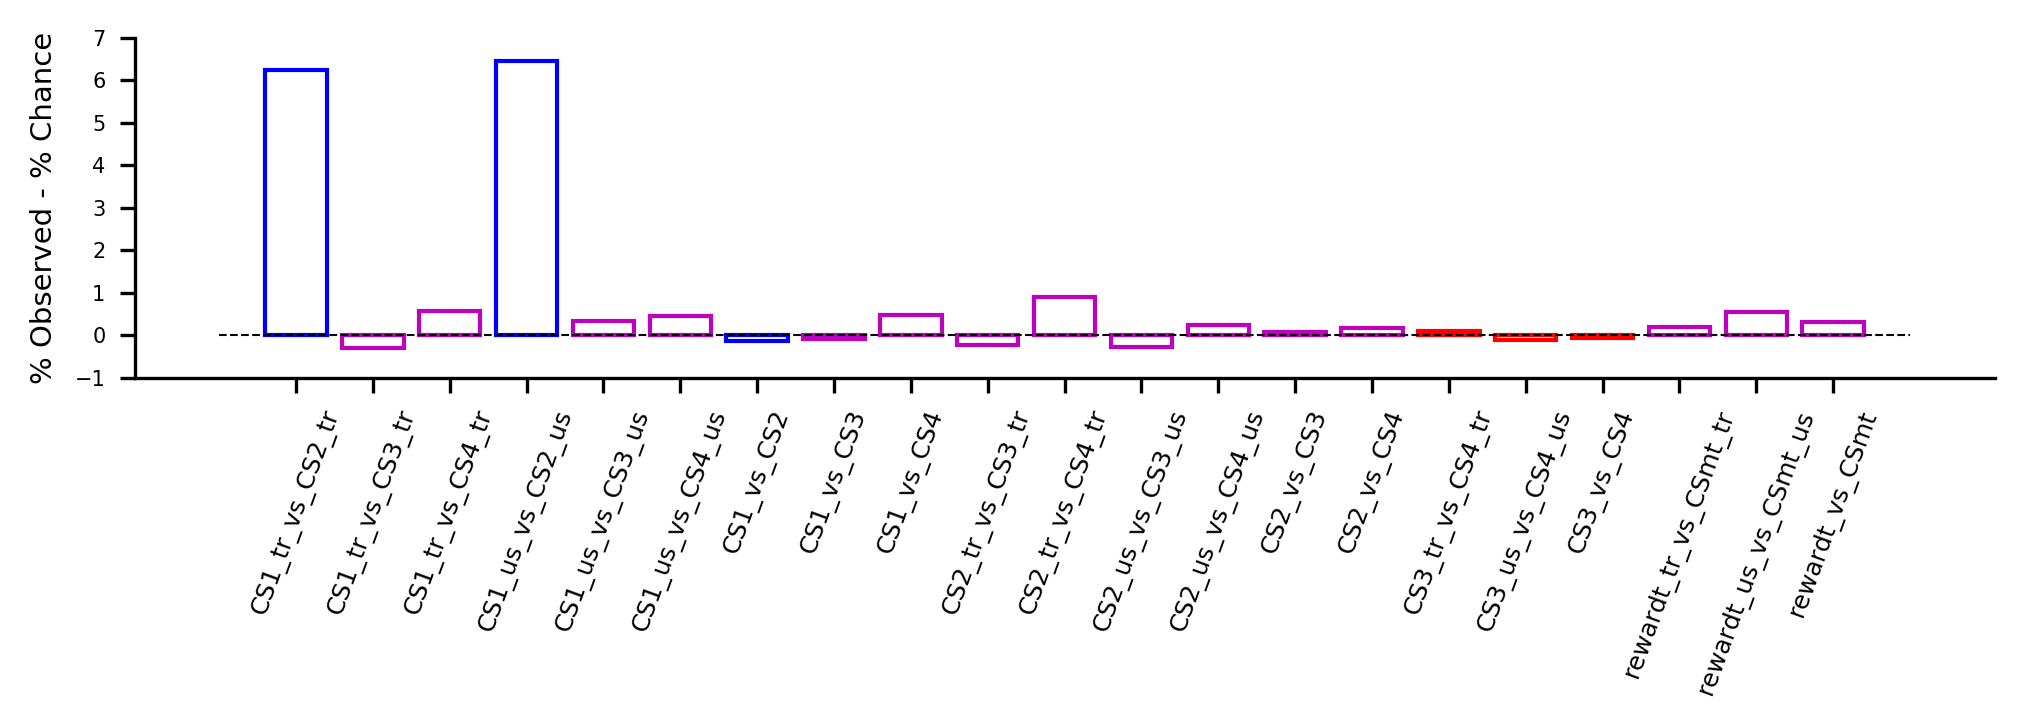

In [37]:
fig, ax = pl.subplots(1, 1, figsize=(8, 1.5))
values = [diff_from_chance[t][2]*100 for t in sorted (diff_from_chance)]
#values = [t[2] for t in diff_from_chance]
pt.plot_bars(values, ax=ax, colors = ['b','m','m','b','m','m','b','m','m','m','m','m','m','m','m','r','r','r','m','m','m'])
ax.set_xticks(range(len(diff_from_chance)))
ax.set_xticklabels(sorted (diff_from_chance), rotation=70, fontsize=6)
pt.nicer_plot(ax)
ax.set_ylim(-1,7)
ax.hlines(0, -1, len(diff_from_chance), 'k', 'dashed')
ax.set_ylabel('% Observed - % Chance')
fig.savefig('../img/vHPC_overlaps_ALL_comparisons_noGrp5_post.jpg')

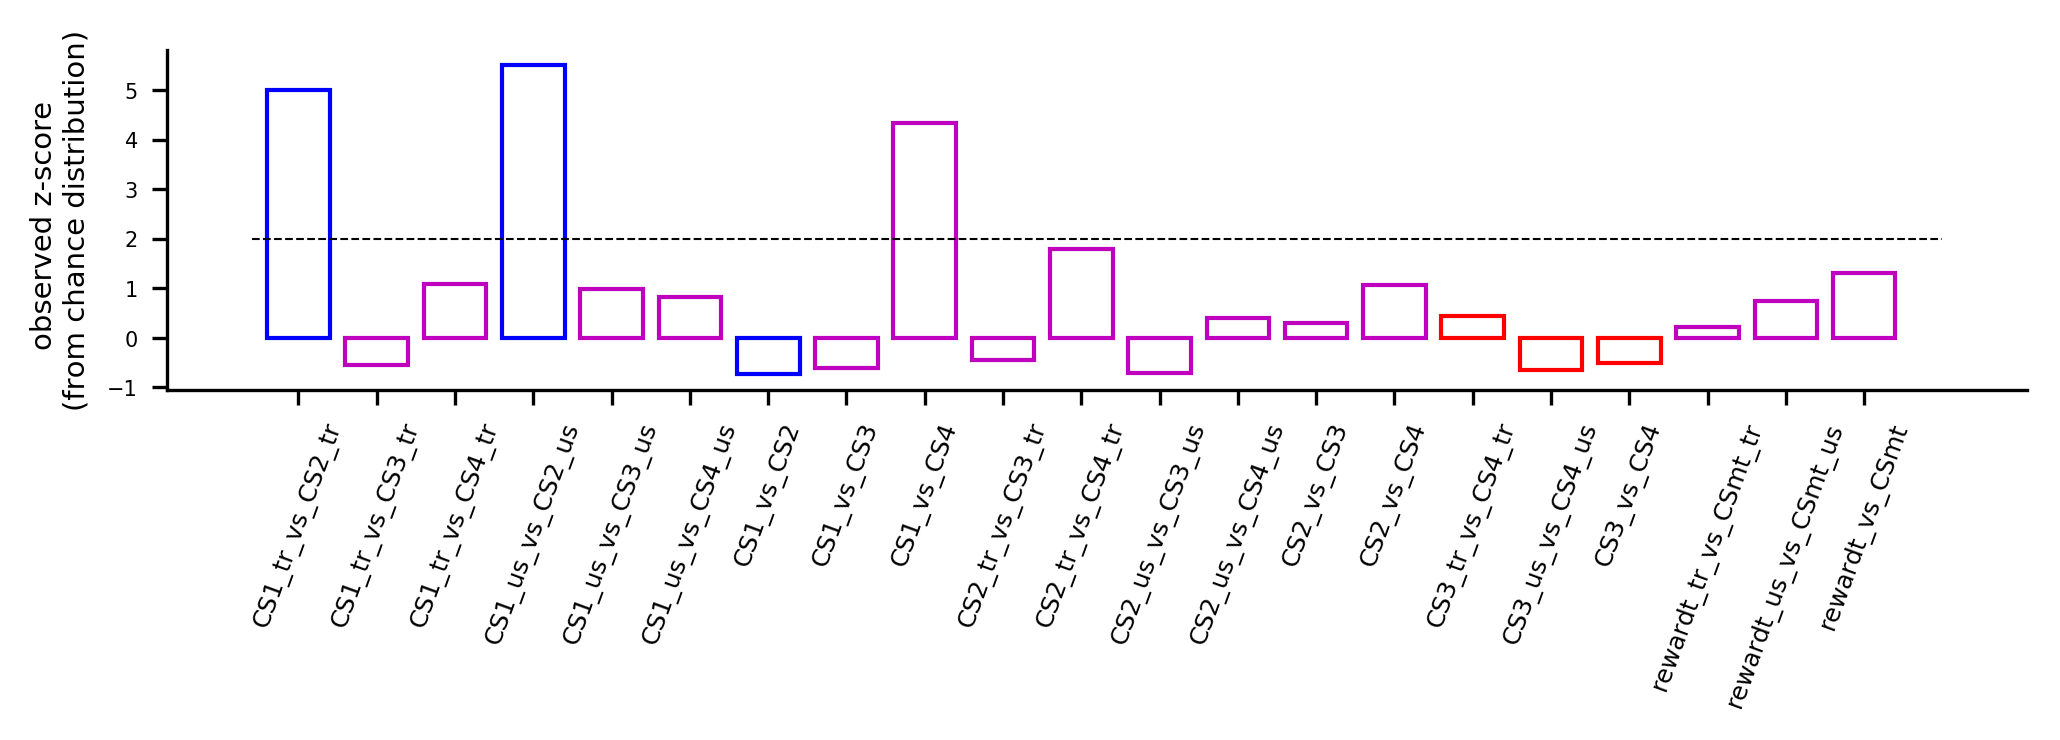

In [38]:
fig, ax = pl.subplots(1, 1, figsize=(8, 1.5))
values = [diff_from_chance[t][4] for t in sorted (diff_from_chance)]
pt.plot_bars(values, ax=ax, colors = ['b','m','m','b','m','m','b','m','m','m','m','m','m','m','m','r','r','r','m','m','m'])
ax.set_xticks(range(len(diff_from_chance)))
ax.set_xticklabels(sorted (diff_from_chance), rotation=70, fontsize=6)
ax.hlines(2, -0.6, len(diff_from_chance), 'k', 'dashed')
pt.nicer_plot(ax)
ax.set_ylabel('observed z-score \n(from chance distribution)')
fig.savefig('../img/vHPC_overlaps_ALL_comparisons_noGrp5_z-score_post.jpg')

_tr


NameError: name 'session' is not defined

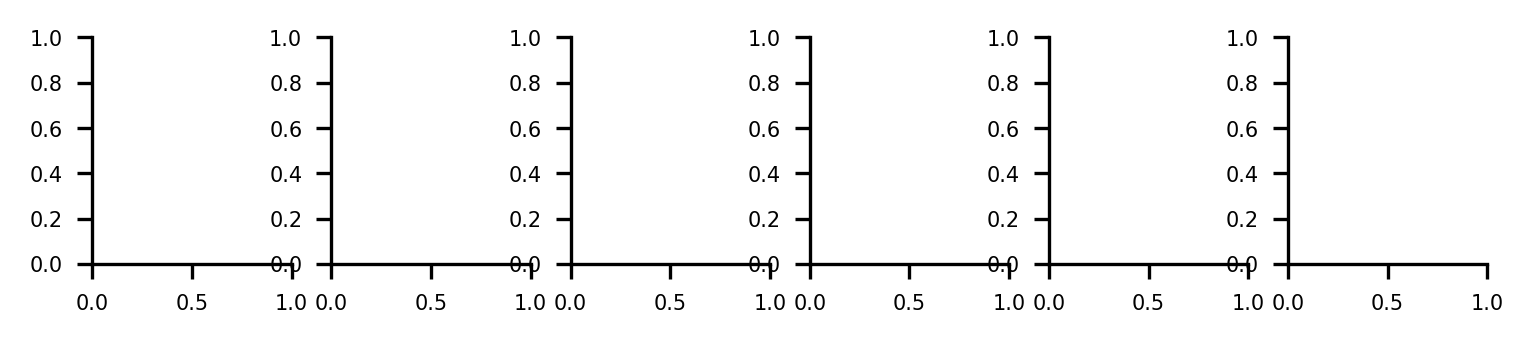

In [39]:
fig, axs = pl.subplots(1, 6, figsize=(6, 1))

f=feature[1]
print f
for s, ax in zip(session, axs):
        pop1 = eval('cells_%sCS_up%s' %(s,f)) + eval('cells_%sCS_dn%s' %(s,f))
        pop2 = eval('cells_%sCSm_up%s' %(s,f))+ eval('cells_%sCSm_dn%s' %(s,f))
        unt = ~(pop1 + pop2)
        t = map(sum, [pop1*~pop2+pop1*pop2, pop2*~pop1+pop1*pop2, unt])
        
        p = ax.pie(t,labels=['Tr+', 'Tr-', 'Unt.'], colors=['m', 'c', '0.7'], autopct=lambda x: "%.1f%%"%(x))
        ax.set_title(s)
        for pp in p[1]:
            pp.set_fontsize(5)
        for pp in p[2]:
            pp.set_fontsize(3)
        
    #    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['csp'])), transform=ax.transAxes, fontsize=3)
    
        ax.set_aspect('equal')


#fig.savefig('../img/overlaps/TRp_v_TRm_combined_pies.pdf', bbox='tight')

In [ ]:
save_workspace(db)